## Imports

In [23]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.regularizers import L2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingClassifier
import random
from sklearn.utils import resample


random.seed(69)

In [24]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

# Leitura do ficheiro

In [25]:
file_path = data_folder / "EventosFinalCompleto.feather"
QuebrasFinal = pd.read_feather(file_path)
QuebrasFinal

,codigo_do_relatorio,concelho,data_do_incidente,nivel_de_tensao,causa_do_incidente,duracao_incidente_min_,n_º_clientes_afetados,tiepi_mt_min_,saifi_mt_#_,saidi_mt_min_,...,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,pr_qtd,MaxHeight,MinHeight
0,EDPD_2018_JAN_T_1,ALMADA,2018-01-02,MT,Escavações,55,828,0.002935,0.000044,0.002456,...,10.70,17.40,2.600,278.25,289.50,2.0,7.800,0.000000,125.0,0.0
1,EDPD_2018_JAN_T_2,SERTA,2018-01-02,MT,Abate De Árvores,163,549,0.002933,0.000177,0.016501,...,10.60,13.80,6.200,249.00,270.00,2.8,8.100,0.000000,1084.0,125.0
2,EDPD_2018_JAN_T_3,FELGUEIRAS,2018-01-04,MT,Deslizamento De Terras,596,3459,0.019228,0.000266,0.035905,...,14.00,14.80,12.900,197.00,180.00,3.9,14.400,4.000000,575.0,145.0
3,EDPD_2018_JAN_T_4,TORRES VEDRAS,2018-01-05,BT,Veículos,178,102,0.000000,0.000000,0.000000,...,12.40,15.10,9.100,288.00,225.00,3.6,13.900,13.200000,394.0,0.0
4,EDPD_2018_JAN_T_5,NISA,2018-01-09,MT,Aves,119,1731,0.004422,0.000155,0.010038,...,4.90,7.80,2.200,137.00,118.00,4.1,15.400,15.900000,463.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,EDPD_2020_DEZ_T_21,POMBAL,2020-12-24,MT,Abate De Árvores,139,2517,0.005941,0.000461,0.017245,...,7.90,12.20,2.100,7.00,351.00,1.7,7.600,0.000000,560.0,0.0
2918,EDPD_2020_DEZ_T_22,VILA NOVA DE GAIA,2020-12-30,MT,Aves,81,3641,0.011914,0.000290,0.011131,...,4.45,9.05,0.275,239.00,186.25,1.5,4.825,0.787500,262.0,0.0
2919,EDPD_2020_DEZ_T_23,ALBUFEIRA,2020-12-28,MT,Escavações,81,3175,0.005974,0.000086,0.005940,...,13.20,15.30,7.700,285.00,293.00,5.8,14.100,0.100000,227.0,0.0
2920,EDPD_2020_DEZ_T_24,CASTRO MARIM,2020-12-28,MT,Veículos,239,591,0.006928,0.000054,0.011528,...,13.20,15.30,7.700,285.00,293.00,5.8,14.100,0.100000,276.0,0.0


In [26]:
QuebrasFinal.columns

Index(['codigo_do_relatorio', 'concelho', 'data_do_incidente',
       'nivel_de_tensao', 'causa_do_incidente', 'duracao_incidente_min_',
       'n_º_clientes_afetados', 'tiepi_mt_min_', 'saifi_mt_#_',
       'saidi_mt_min_', 'end_mwh_', 'saifi_bt_#_', 'saidi_bt_min_', 'decisao',
       'distrito', 'densidade_populacional', 'populacao_residente',
       'setor_primario', 'setor_secundario', 'setor_terciario',
       'indice_de_envelhecimento', 'rural', 'count_zonaa', 'count_zonab',
       'count_zonac', 'total_concelho_zonas', 'percentagem_zonaa',
       'percentagem_zonab', 'percentagem_zonac', 'soma_degree_rede_concelho',
       'n_subestacoes_concelho', 'classe_da_causa_4', 'classe_da_causa_6',
       'perc_prim', 'perc_sec', 'perc_terc', 'sen_ano', 'cos_ano', 'sen_mes',
       'cos_mes', 't_med', 't_max', 't_min', 'dd_med', 'dd_ffx', 'ff_med',
       'ff_max', 'pr_qtd', 'MaxHeight', 'MinHeight'],
      dtype='object')

In [27]:
QuebrasContar = QuebrasFinal[["distrito", "concelho", "data_do_incidente"]].groupby(["distrito", "concelho", "data_do_incidente"]).size().reset_index(name='número_de_eventos')
QuebrasContar

,distrito,concelho,data_do_incidente,número_de_eventos
0,AVEIRO,AGUEDA,2018-01-25,1
1,AVEIRO,AGUEDA,2018-04-12,1
2,AVEIRO,AGUEDA,2018-07-10,1
3,AVEIRO,AGUEDA,2018-08-24,1
4,AVEIRO,AGUEDA,2018-10-13,1
...,...,...,...,...
2819,VISEU,VOUZELA,2019-01-25,1
2820,VISEU,VOUZELA,2021-02-04,1
2821,VISEU,VOUZELA,2021-06-02,1
2822,VISEU,VOUZELA,2023-01-12,1


In [28]:
QuebrasContar["número_de_eventos"].unique()

array([1, 2, 3, 4], dtype=int64)

In [29]:
datas = pd.date_range(start='2018-01-01', end='2023-12-31', freq='D')
df_referencia = pd.DataFrame({'data_do_incidente': datas})
df_referencia

,data_do_incidente
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
2186,2023-12-27
2187,2023-12-28
2188,2023-12-29
2189,2023-12-30


In [30]:
combinacoes = QuebrasFinal[['concelho', 'distrito']].drop_duplicates()
combinacoes

,concelho,distrito
0,ALMADA,SETUBAL
1,SERTA,CASTELO-BRANCO
2,FELGUEIRAS,PORTO
3,TORRES VEDRAS,LISBOA
4,NISA,PORTALEGRE
...,...,...
2593,CUBA,BEJA
2640,MIRANDA DO DOURO,BRAGANCA
2708,FIGUEIRA DE CASTELO RODRIGO,GUARDA
2765,SERNANCELHE,VISEU


In [31]:
merged_df = pd.merge(df_referencia.assign(key=0), combinacoes.assign(key=0), on='key', how='outer')
merged_df

,data_do_incidente,key,concelho,distrito
0,2018-01-01,0,ALMADA,SETUBAL
1,2018-01-01,0,SERTA,CASTELO-BRANCO
2,2018-01-01,0,FELGUEIRAS,PORTO
3,2018-01-01,0,TORRES VEDRAS,LISBOA
4,2018-01-01,0,NISA,PORTALEGRE
...,...,...,...,...
560891,2023-12-31,0,CUBA,BEJA
560892,2023-12-31,0,MIRANDA DO DOURO,BRAGANCA
560893,2023-12-31,0,FIGUEIRA DE CASTELO RODRIGO,GUARDA
560894,2023-12-31,0,SERNANCELHE,VISEU


In [32]:
# Juntar os valores originais da coluna 'Número de Eventos' (presumo que 'QuebrasContarOriginal' seja o dataframe original com os dados)
merged_df = pd.merge(merged_df, QuebrasContar, on=['concelho', 'distrito', 'data_do_incidente'], how='left', suffixes=('', '_original'))

# Preencher os valores nulos na coluna 'Número de Eventos' com 0
merged_df['número_de_eventos'] = merged_df['número_de_eventos'].fillna(0).astype(int)

# Remover colunas extras
merged_df.drop(['key'], axis=1, inplace=True)

# Visualizar DB
merged_df

,data_do_incidente,concelho,distrito,número_de_eventos
0,2018-01-01,ALMADA,SETUBAL,0
1,2018-01-01,SERTA,CASTELO-BRANCO,0
2,2018-01-01,FELGUEIRAS,PORTO,0
3,2018-01-01,TORRES VEDRAS,LISBOA,0
4,2018-01-01,NISA,PORTALEGRE,0
...,...,...,...,...
560891,2023-12-31,CUBA,BEJA,0
560892,2023-12-31,MIRANDA DO DOURO,BRAGANCA,0
560893,2023-12-31,FIGUEIRA DE CASTELO RODRIGO,GUARDA,0
560894,2023-12-31,SERNANCELHE,VISEU,0


In [33]:
merged_df.iloc[980]

data_do_incidente     2018-01-04 00:00:00
concelho             VILA NOVA DE FOZ COA
distrito                           GUARDA
número_de_eventos                       0
Name: 980, dtype: object

In [34]:
merged_df["número_de_eventos"].unique()

array([0, 1, 2, 3, 4])

In [35]:
merged_df['dia'] = merged_df['data_do_incidente'].dt.day
merged_df['mês'] = merged_df['data_do_incidente'].dt.month
merged_df['ano'] = merged_df['data_do_incidente'].dt.year

merged_df

,data_do_incidente,concelho,distrito,número_de_eventos,dia,mês,ano
0,2018-01-01,ALMADA,SETUBAL,0,1,1,2018
1,2018-01-01,SERTA,CASTELO-BRANCO,0,1,1,2018
2,2018-01-01,FELGUEIRAS,PORTO,0,1,1,2018
3,2018-01-01,TORRES VEDRAS,LISBOA,0,1,1,2018
4,2018-01-01,NISA,PORTALEGRE,0,1,1,2018
...,...,...,...,...,...,...,...
560891,2023-12-31,CUBA,BEJA,0,31,12,2023
560892,2023-12-31,MIRANDA DO DOURO,BRAGANCA,0,31,12,2023
560893,2023-12-31,FIGUEIRA DE CASTELO RODRIGO,GUARDA,0,31,12,2023
560894,2023-12-31,SERNANCELHE,VISEU,0,31,12,2023


# Juntar Zonas

In [36]:
zonas = QuebrasFinal[['distrito', 'concelho', 'count_zonaa', 'count_zonab', 'count_zonac', 't_med', 't_max', 't_min', 'dd_med', 'dd_ffx', 'ff_med',
       'ff_max', 'pr_qtd', 'MaxHeight', 'MinHeight']].groupby(['distrito', 'concelho', 'count_zonaa', 'count_zonab', 'count_zonac', 't_med', 't_max', 't_min', 'dd_med', 'dd_ffx', 'ff_med',
       'ff_max', 'pr_qtd', 'MaxHeight', 'MinHeight']).mean().reset_index()
zonas

,distrito,concelho,count_zonaa,count_zonab,count_zonac,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,pr_qtd,MaxHeight,MinHeight
0,AVEIRO,AGUEDA,0,7,20,9.5,15.0,5.3,126.000000,102.000000,1.10,4.900000,0.0,762.0,4.0
1,AVEIRO,AGUEDA,0,7,20,10.0,16.4,5.0,64.000000,6.000000,1.50,4.600000,0.0,762.0,4.0
2,AVEIRO,AGUEDA,0,7,20,10.5,15.1,7.3,163.000000,307.000000,1.60,5.700000,0.0,762.0,4.0
3,AVEIRO,AGUEDA,0,7,20,10.8,14.3,9.0,172.000000,150.000000,2.70,11.000000,19.9,762.0,4.0
4,AVEIRO,AGUEDA,0,7,20,11.0,14.8,8.4,94.000000,103.000000,2.60,9.400000,0.0,762.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2819,VISEU,VOUZELA,0,0,16,10.3,16.8,5.3,45.000000,28.000000,4.40,9.600000,0.0,1043.0,125.0
2820,VISEU,VOUZELA,0,0,16,13.6,19.0,9.5,218.000000,219.000000,3.60,10.100000,0.0,1043.0,125.0
2821,VISEU,VOUZELA,0,0,16,17.8,24.5,11.7,206.166667,249.833333,2.25,9.666667,0.0,1043.0,125.0
2822,VISEU,VOUZELA,0,0,16,24.3,31.1,19.6,337.000000,315.000000,2.60,7.400000,0.0,1043.0,125.0


In [37]:
merged_df = pd.merge(merged_df, zonas, on=['concelho', 'distrito'], how = 'outer')
merged_df

,data_do_incidente,concelho,distrito,número_de_eventos,dia,mês,ano,count_zonaa,count_zonab,count_zonac,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,pr_qtd,MaxHeight,MinHeight
0,2018-01-01,ALMADA,SETUBAL,0,1,1,2018,102,63,14,6.0,10.3,3.8,9.00,1.0,3.8,12.4,0.0,125.0,0.0
1,2018-01-01,ALMADA,SETUBAL,0,1,1,2018,102,63,14,10.7,17.4,2.6,278.25,289.5,2.0,7.8,0.0,125.0,0.0
2,2018-01-01,ALMADA,SETUBAL,0,1,1,2018,102,63,14,11.2,19.1,4.6,25.00,357.0,1.3,5.5,0.0,125.0,0.0
3,2018-01-01,ALMADA,SETUBAL,0,1,1,2018,102,63,14,12.9,17.5,9.4,56.00,65.0,1.6,8.0,4.3,125.0,0.0
4,2018-01-01,ALMADA,SETUBAL,0,1,1,2018,102,63,14,13.2,19.0,10.0,28.00,84.0,1.9,8.0,0.0,125.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6187379,2023-12-27,RESENDE,VISEU,0,27,12,2023,0,0,9,25.1,32.6,17.8,33.00,62.0,4.3,9.4,0.0,1218.0,50.0
6187380,2023-12-28,RESENDE,VISEU,0,28,12,2023,0,0,9,25.1,32.6,17.8,33.00,62.0,4.3,9.4,0.0,1218.0,50.0
6187381,2023-12-29,RESENDE,VISEU,0,29,12,2023,0,0,9,25.1,32.6,17.8,33.00,62.0,4.3,9.4,0.0,1218.0,50.0
6187382,2023-12-30,RESENDE,VISEU,0,30,12,2023,0,0,9,25.1,32.6,17.8,33.00,62.0,4.3,9.4,0.0,1218.0,50.0


In [38]:
merged_df = merged_df.dropna()
merged_df 

,data_do_incidente,concelho,distrito,número_de_eventos,dia,mês,ano,count_zonaa,count_zonab,count_zonac,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,pr_qtd,MaxHeight,MinHeight
0,2018-01-01,ALMADA,SETUBAL,0,1,1,2018,102,63,14,6.0,10.3,3.8,9.00,1.0,3.8,12.4,0.0,125.0,0.0
1,2018-01-01,ALMADA,SETUBAL,0,1,1,2018,102,63,14,10.7,17.4,2.6,278.25,289.5,2.0,7.8,0.0,125.0,0.0
2,2018-01-01,ALMADA,SETUBAL,0,1,1,2018,102,63,14,11.2,19.1,4.6,25.00,357.0,1.3,5.5,0.0,125.0,0.0
3,2018-01-01,ALMADA,SETUBAL,0,1,1,2018,102,63,14,12.9,17.5,9.4,56.00,65.0,1.6,8.0,4.3,125.0,0.0
4,2018-01-01,ALMADA,SETUBAL,0,1,1,2018,102,63,14,13.2,19.0,10.0,28.00,84.0,1.9,8.0,0.0,125.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6187379,2023-12-27,RESENDE,VISEU,0,27,12,2023,0,0,9,25.1,32.6,17.8,33.00,62.0,4.3,9.4,0.0,1218.0,50.0
6187380,2023-12-28,RESENDE,VISEU,0,28,12,2023,0,0,9,25.1,32.6,17.8,33.00,62.0,4.3,9.4,0.0,1218.0,50.0
6187381,2023-12-29,RESENDE,VISEU,0,29,12,2023,0,0,9,25.1,32.6,17.8,33.00,62.0,4.3,9.4,0.0,1218.0,50.0
6187382,2023-12-30,RESENDE,VISEU,0,30,12,2023,0,0,9,25.1,32.6,17.8,33.00,62.0,4.3,9.4,0.0,1218.0,50.0


In [39]:
merged_df.columns

Index(['data_do_incidente', 'concelho', 'distrito', 'número_de_eventos', 'dia',
       'mês', 'ano', 'count_zonaa', 'count_zonab', 'count_zonac', 't_med',
       't_max', 't_min', 'dd_med', 'dd_ffx', 'ff_med', 'ff_max', 'pr_qtd',
       'MaxHeight', 'MinHeight'],
      dtype='object')

In [41]:
teste = merged_df[merged_df["distrito"] == "LISBOA"]
teste

,data_do_incidente,concelho,distrito,número_de_eventos,dia,mês,ano,count_zonaa,count_zonab,count_zonac,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,pr_qtd,MaxHeight,MinHeight
135842,2018-01-01,TORRES VEDRAS,LISBOA,0,1,1,2018,0,27,40,12.2,17.2,7.4,51.0,51.0,2.3,5.8,0.0,394.0,0.0
135843,2018-01-01,TORRES VEDRAS,LISBOA,0,1,1,2018,0,27,40,12.4,13.8,11.3,58.0,354.0,0.7,4.5,0.1,394.0,0.0
135844,2018-01-01,TORRES VEDRAS,LISBOA,0,1,1,2018,0,27,40,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2,394.0,0.0
135845,2018-01-01,TORRES VEDRAS,LISBOA,0,1,1,2018,0,27,40,17.9,22.1,14.6,347.0,0.0,3.0,11.5,0.0,394.0,0.0
135846,2018-01-01,TORRES VEDRAS,LISBOA,0,1,1,2018,0,27,40,20.7,27.4,17.4,339.0,354.0,4.0,15.4,0.0,394.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6101930,2023-12-30,LOURINHA,LISBOA,1,30,12,2023,0,8,12,15.6,18.5,11.4,223.0,180.0,5.3,15.9,11.7,201.0,0.0
6101931,2023-12-30,LOURINHA,LISBOA,1,30,12,2023,0,8,12,17.3,19.0,14.7,260.0,264.0,6.3,17.4,3.1,201.0,0.0
6101932,2023-12-31,LOURINHA,LISBOA,0,31,12,2023,0,8,12,10.9,14.8,6.8,50.0,84.0,2.0,5.1,0.5,201.0,0.0
6101933,2023-12-31,LOURINHA,LISBOA,0,31,12,2023,0,8,12,15.6,18.5,11.4,223.0,180.0,5.3,15.9,11.7,201.0,0.0


## Modelling

In [42]:
# Selecionar apenas as colunas relevantes
features = ['count_zonaa', 'count_zonab', 'count_zonac', 't_med',
       't_max', 't_min', 'dd_med', 'dd_ffx', 'ff_med', 'ff_max', 'pr_qtd',
       'MaxHeight', 'MinHeight']
target = 'número_de_eventos'
X = teste[features].values
y = teste[target].values

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calcular a proporção de classes
class_weights = len(y_train) / (5 * np.bincount(y_train.astype(int)))

# Definir a função de peso de amostra
def sample_weight_function(y):
    return class_weights[y.astype(int)]

# Construir o modelo LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, kernel_regularizer=L2(0.001), input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(units=50, kernel_regularizer=L2(0.001)),
    Dropout(0.3),
    Dense(1, kernel_regularizer=L2(0.001), activation='linear')  # Ativação linear para regressão
])

# Compilar o modelo
model.compile(optimizer=Adam(), loss='mse')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1, sample_weight=sample_weight_function(y_train))

# Avaliar o modelo
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

Epoch 1/20


C:\Users\diogo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13234/13234 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - loss: 0.4696 - val_loss: 0.3369
Epoch 2/20
13234/13234 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 0.3800 - val_loss: 0.3102
Epoch 3/20
13234/13234 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 0.3609 - val_loss: 0.3111
Epoch 4/20
13234/13234 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 0.3472 - val_loss: 0.3171
Epoch 5/20
13234/13234 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 0.3686 - val_loss: 0.3140
Epoch 6/20
13234/13234 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 0.3480 - val_loss: 0.3360
Epoch 7/20
13234/13234 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - loss: 0.3610 - val_loss: 0.3124
Epoch 8/20
13234/13234 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - loss: 0.3433 - val_loss: 0.3213
Epoch 9/20
13234/13234 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - loss: 0.3515 - val_loss: 0.3176
Epoch 10/20
13234/13234 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - loss: 0.3350 - val_loss: 0.3055
Epoch 11/20
13234/13234 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - loss: 0.3393 - val_loss: 0.2958
Epoch 12

In [43]:
# Fazer previsões com o modelo
y_pred = model.predict(X_test)

# Calcular o erro quadrático médio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


4136/4136 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Mean Squared Error: 0.6427705933526686
R-squared: -27.636175094911906


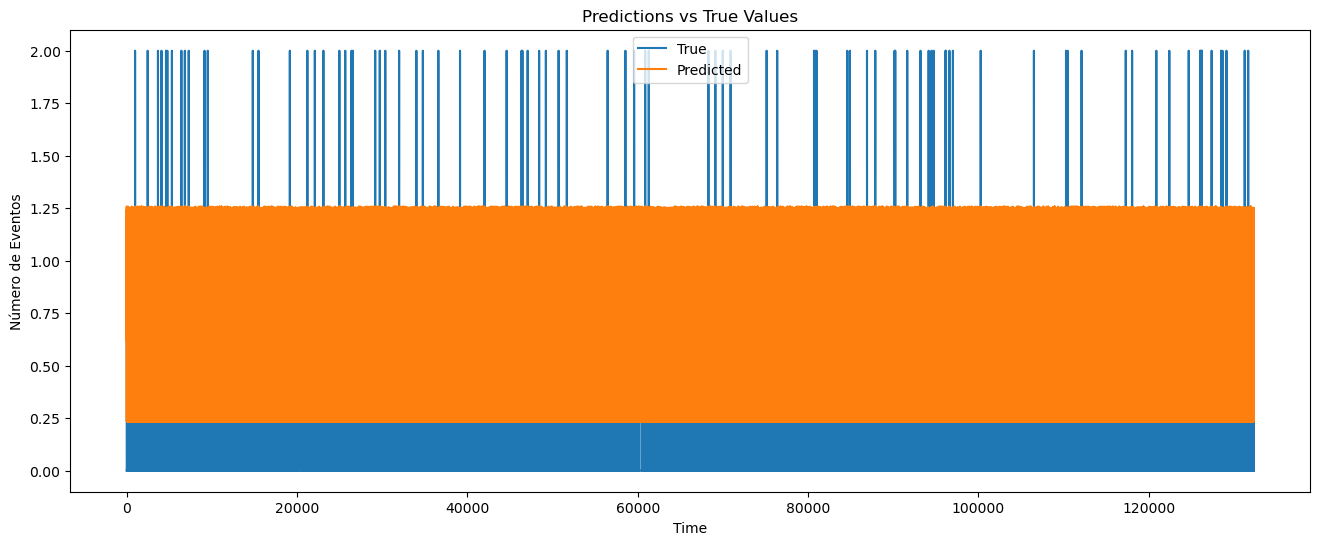

In [45]:
# Plotar as previsões vs. os valores reais
plt.figure(figsize=(16, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Número de Eventos')
plt.title('Predictions vs True Values')
plt.legend()
plt.savefig('LSTMcount')
plt.show()
